<a href="https://colab.research.google.com/github/sidrusiya/AILA_Tasks/blob/main/AILA_Task1_B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset and Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import seaborn as sns
import gensim
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

In [ ]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1/'
list_dir = os.listdir(PATH)
text = []
labels = []
for file in list_dir:
    file_path = PATH + file
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])

data = {'Text': text, "labels": labels}
dataset1 = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset1.head()

,Text,labels
0,Leave granted,Facts
1,Interpretation of the provisions of S.46(1)(b)...,Facts
2,"The factual matrix of the matter,which is not ...",Facts
3,First Respondent is the registered proprietor ...,Facts
4,Jain Industries got the trade mark 'Field Mars...,Facts


In [ ]:
dataset1.shape

(11285, 2)

# **Data Preprocessing**

In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
event_types_dict = {}
for num, name in enumerate(list(dataset1['labels'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Facts': 0, 'Argument': 1, 'Ratio of the decision': 2, 'Statute': 3, 'Precedent': 4, 'Ruling by Present Court': 5, 'Ruling by Lower Court': 6}
{0: 'Facts', 1: 'Argument', 2: 'Ratio of the decision', 3: 'Statute', 4: 'Precedent', 5: 'Ruling by Present Court', 6: 'Ruling by Lower Court'}


In [ ]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Facts'))
dataset1['num_labels'] = dataset1['labels'].apply(text_to_numerical_category)
dataset1

0


,Text,labels,num_labels
0,Leave granted,Facts,0
1,Interpretation of the provisions of S.46(1)(b)...,Facts,0
2,"The factual matrix of the matter,which is not ...",Facts,0
3,First Respondent is the registered proprietor ...,Facts,0
4,Jain Industries got the trade mark 'Field Mars...,Facts,0
...,...,...,...
11280,P.W. 4 the Manager was asked in cross-examinat...,Ratio of the decision,2
11281,While these passages might show that no notice...,Ratio of the decision,2
11282,in it has been held that the appellant was not...,Ratio of the decision,2
11283,"In the view we have taken, the appeal has no s...",Ruling by Present Court,5


# **Lowering the characters and removing the stopwords**

In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
import sys
text = []
lem_text = []
for i in dataset1.index:
    dataset1['Text'][i] = remove_size(dataset1['Text'][i])
    dataset1['Text'][i] = remove_months(dataset1['Text'][i])
    dataset1['Text'][i] = remove_nums(dataset1['Text'][i])
    dataset1['Text'][i] = remove_comma(dataset1['Text'][i])
    temp = dataset1['Text'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

# **Tokenization**

In [ ]:
for i in range(len(text)):
    text[i] = text[i].split()

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

# **Stemmation**

In [ ]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

# **Lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

# **Recombining Tokens**

In [ ]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'leav grant'

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

'leave granted'

In [ ]:
dataset1['lem_text'] = np.array(lem_text)
dataset1['stem_text'] = np.array(text)

dataset1

,Text,labels,num_labels,lem_text,stem_text
0,Leave granted,Facts,0,leave granted,leav grant
1,Interpretation of the provisions of S.()(b) of...,Facts,0,interpretation provision s.()(b) trade merchan...,interpret provis s.()(b) trade merchandis mark...
2,The factual matrix of the matterwhich is not m...,Facts,0,factual matrix matterwhich much dispute,factual matrix matterwhich much disput
3,First Respondent is the registered proprietor ...,Facts,0,first respondent registered proprietor trade m...,first respond regist proprietor trade mark 'fi...
4,Jain Industries got the trade mark 'Field Mars...,Facts,0,jain industry got trade mark 'field marshal' r...,jain industri got trade mark 'field marshal' r...
...,...,...,...,...,...
11280,P.W. the Manager was asked in cross-examinati...,Ratio of the decision,2,p.w. manager asked cross-examination whether g...,p.w. manag ask cross-examin whether given prio...
11281,While these passages might show that no notice...,Ratio of the decision,2,passage might show notice eviction given even ...,passag might show notic evict given even stage...
11282,in it has been held that the appellant was not...,Ratio of the decision,2,held appellant mere trespasser deliberately en...,held appel mere trespass deliber enter upon la...
11283,In the view we have taken the appeal has no su...,Ruling by Present Court,5,view taken appeal substance accordingly dismis...,view taken appeal substanc accordingli dismiss...


In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
dataset1.drop_duplicates(['lem_text']).labels.value_counts()

Ratio of the decision      4136
Facts                      2570
Precedent                  1758
Argument                    904
Statute                     869
Ruling by Lower Court       477
Ruling by Present Court     276
Name: labels, dtype: int64

# **Handling Imbalanced Dataset**

In [ ]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 1500
THRESH_2 = 500

for group in dataset1.labels.unique():
    if len(dataset1.groupby('labels').get_group(group).stem_text.unique()) > THRESH_1:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        labels += ([group]*2*len(list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique()))))

    elif len(dataset1.groupby('labels').get_group(group).stem_text.unique()) > THRESH_2:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        labels += ([group]*3*len(list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique()))))
    else:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique())))
        labels += ([group]*5*len(list(shuffle(dataset1.groupby('labels').get_group(group).stem_text.unique()))))

In [ ]:
len(lemm)

26197

In [ ]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [ ]:
balanced_df.Labels.value_counts()

Ratio of the decision      8322
Facts                      5164
Precedent                  3530
Argument                   2757
Statute                    2619
Ruling by Lower Court      2410
Ruling by Present Court    1395
Name: Labels, dtype: int64

In [ ]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [ ]:
balanced_df.head()

,Text,Labels,NumLabel
0,"""revoc petitions"" file respond .",Facts,0
1,disput aros bhupendra jnanendra nagendra son r...,Facts,0
2,leav appeal suprem court grant appeal admit th...,Facts,0
3,refer number i.t.no.,Facts,0
4,forens scienc laboratori confirm presenc group...,Facts,0


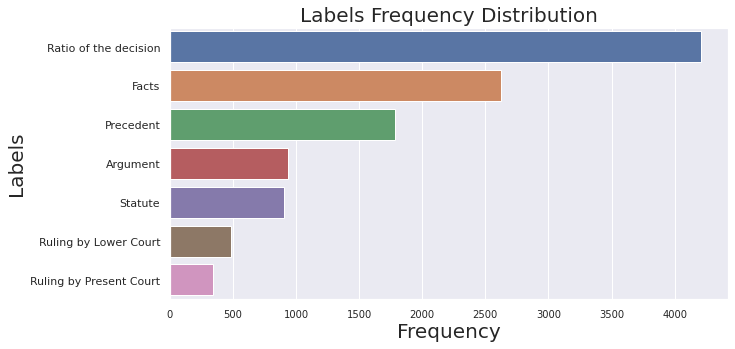

In [ ]:
sns.set_theme(style="darkgrid")
x = dataset1['labels'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Labels Frequency Distribution", fontsize=20)
plt.ylabel('Labels', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

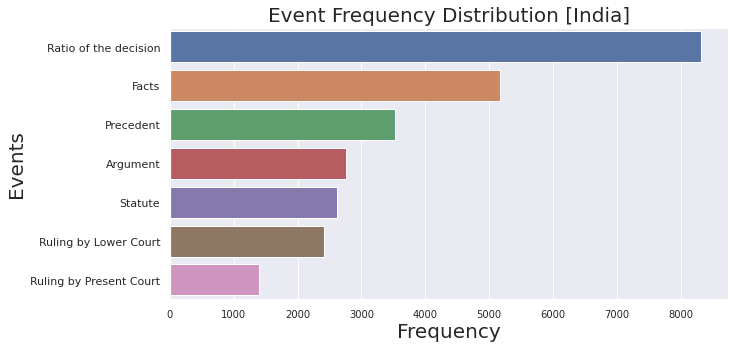

In [ ]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

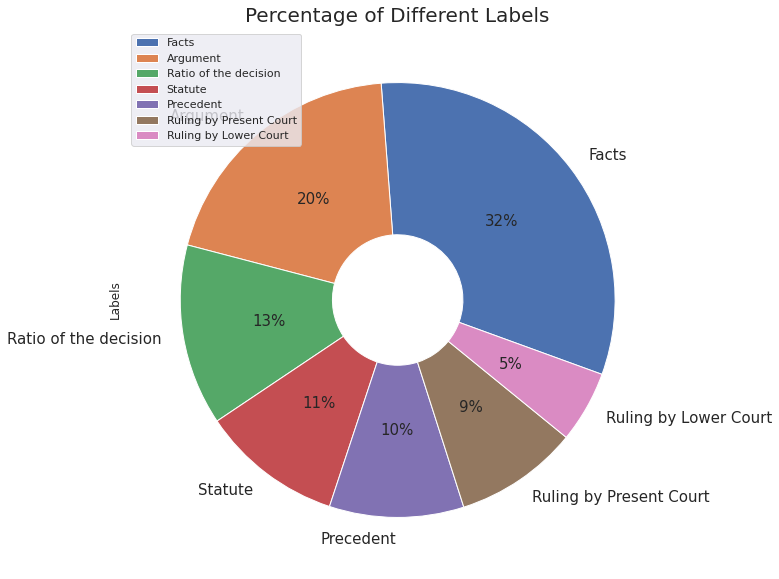

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
balanced_df.Labels.value_counts().plot(kind='pie', labels= balanced_df.Labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

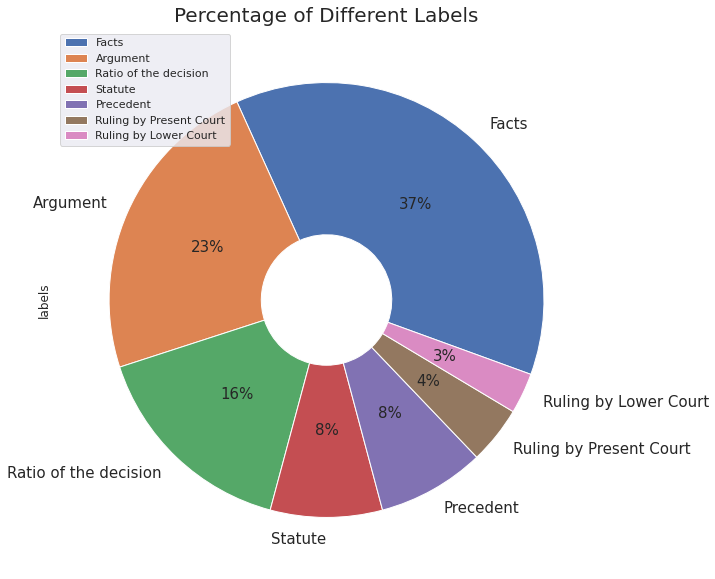

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
dataset1.labels.value_counts().plot(kind='pie', labels= dataset1.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

# **BERT**

**Tokenization**

In [ ]:
max_classes = len(balanced_df.Labels.unique())

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(balanced_df)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(balanced_df.Text, balanced_df.NumLabel, test_size = 0.1, random_state = 42, stratify =balanced_df.NumLabel)

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_model_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(bert_model_preprocessing_link)

In [ ]:
bert_model = hub.KerasLayer(bert_model_link)

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name='input-text')
    preprocessing_layer = hub.KerasLayer(bert_model_preprocessing_link, name='bert-preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_link, trainable=True, name='bert-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units= 512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units=max_classes, activation='softmax', name='classifer')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(sample_text))

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 bert-preprocessing (KerasLayer  {'input_type_ids':   0          ['input-text[0][0]']             
 )                              (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  


**Label** **Encoding**

In [ ]:
max_classes = len(balanced_df.Labels.unique())

In [ ]:
%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs



# **Hyperparameters**

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 4
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate=0.,
                               decay_steps=num_train_steps
                               )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('/content/checkpoints',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               save_weights_only = False)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

# **Class Weight Balancing**

In [ ]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([0.72471506, 1.35742785, 0.44970302, 1.42895325, 1.06017807,
       2.6827445 , 1.55287493])

In [ ]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.7247150603076242,
 1: 1.3574278460023836,
 2: 0.4497030246850002,
 3: 1.4289532536955218,
 4: 1.0601780655605018,
 5: 2.6827444956477215,
 6: 1.5528749259039716}

# **Building Model**

In [ ]:
import tensorflow_addons as tfa

macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

metrics = [categorical_accuracry, micro_f1, precision, recall]

In [ ]:
classifier_model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_labels_train)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_labels_test)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
classifier_model.fit(train_dataset,
                     validation_data=test_dataset,
                 epochs = EPOCHS,
                 verbose = 1,
                 class_weight=class_weights,
                 callbacks = [MyCheckpoint, MyEarlyStopping]
          )

Epoch 1/4
737/737 [==============================] - ETA: 0s - loss: 1.2990 - categorical_accuracy: 0.4516 - f1_score: 0.4516 - precision: 0.6527 - recall: 0.2520
Epoch 00001: val_categorical_accuracy improved from -inf to 0.62328, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


737/737 [==============================] - 1325s 2s/step - loss: 1.2990 - categorical_accuracy: 0.4516 - f1_score: 0.4516 - precision: 0.6527 - recall: 0.2520 - val_loss: 1.0004 - val_categorical_accuracy: 0.6233 - val_f1_score: 0.6233 - val_precision: 0.6959 - val_recall: 0.4901
Epoch 2/4
737/737 [==============================] - ETA: 0s - loss: 0.5736 - categorical_accuracy: 0.7171 - f1_score: 0.7171 - precision: 0.7659 - recall: 0.6441
Epoch 00002: val_categorical_accuracy improved from 0.62328 to 0.79008, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


737/737 [==============================] - 1297s 2s/step - loss: 0.5736 - categorical_accuracy: 0.7171 - f1_score: 0.7171 - precision: 0.7659 - recall: 0.6441 - val_loss: 0.5697 - val_categorical_accuracy: 0.7901 - val_f1_score: 0.7901 - val_precision: 0.8109 - val_recall: 0.7660
Epoch 3/4
737/737 [==============================] - ETA: 0s - loss: 0.2958 - categorical_accuracy: 0.8471 - f1_score: 0.8471 - precision: 0.8642 - recall: 0.8281
Epoch 00003: val_categorical_accuracy improved from 0.79008 to 0.87328, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


737/737 [==============================] - 1301s 2s/step - loss: 0.2958 - categorical_accuracy: 0.8471 - f1_score: 0.8471 - precision: 0.8642 - recall: 0.8281 - val_loss: 0.3746 - val_categorical_accuracy: 0.8733 - val_f1_score: 0.8733 - val_precision: 0.8850 - val_recall: 0.8634
Epoch 4/4
737/737 [==============================] - ETA: 0s - loss: 0.1626 - categorical_accuracy: 0.9181 - f1_score: 0.9181 - precision: 0.9260 - recall: 0.9111
Epoch 00004: val_categorical_accuracy improved from 0.87328 to 0.89618, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


737/737 [==============================] - 1300s 2s/step - loss: 0.1626 - categorical_accuracy: 0.9181 - f1_score: 0.9181 - precision: 0.9260 - recall: 0.9111 - val_loss: 0.3614 - val_categorical_accuracy: 0.8962 - val_f1_score: 0.8962 - val_precision: 0.9023 - val_recall: 0.8920


In [ ]:
classifier_model.save('BERT-Model.h5')

# **Testing**

In [ ]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1_Test/'
list_dir = os.listdir(PATH)
text = []
labels = []
sentid = []
i=0
for file in list_dir:
    file_path = PATH + file
    j=1
    i=i+1
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])
            sentid.append("d"+str(i)+"_s"+str(j))
            j=j+1

data = {'ID': sentid, 'Text': text, "labels": labels}
test_file = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['Text'].apply(text_cleaning)

In [ ]:
test_file

,ID,Text,labels,processed
0,d1_s1,The present appeal has been filed against the ...,Facts,the present appeal has been filed against the ...
1,d1_s2,Brief facts:,Facts,brief facts:
2,d1_s3,(a) One Shri Lal Babu Priyadarshi the appellan...,Facts,(a) one shri lal babu priyadarshi the appellan...
3,d1_s4,(b) One Shri Amritpal Singh the respondent her...,Facts,(b) one shri amritpal singh the respondent her...
4,d1_s5,The respondent herein filed a Notice of Opposi...,Facts,the respondent herein filed a notice of opposi...
...,...,...,...,...
692,d10_s54,The appellant State has taken the stand that t...,Ratio of the decision,the appellant state has taken the stand that t...
693,d10_s55,In the view that we take that Article 311 has ...,Ratio of the decision,in the view that we take that article has no. ...
694,d10_s56,"In the result the order of the High Court, dat...",Ruling by Present Court,in the result the order of the high court date...
695,d10_s57,"In the circumstances of the case, there will b...",Ruling by Present Court,in the circumstances of the case there will be...


In [ ]:
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_file.head()

,ID,Text,labels,processed
0,d1_s1,The present appeal has been filed against the ...,Facts,present appeal filed order dated .. passed int...
1,d1_s2,Brief facts:,Facts,brief fact :
2,d1_s3,(a) One Shri Lal Babu Priyadarshi the appellan...,Facts,( ) one shri lal babu priyadarshi appellant he...
3,d1_s4,(b) One Shri Amritpal Singh the respondent her...,Facts,( b ) one shri amritpal singh respondent herei...
4,d1_s5,The respondent herein filed a Notice of Opposi...,Facts,respondent herein filed notice opposition oppo...


In [ ]:
y_preds = np.argmax(classifier_model.predict(test_file.processed), axis=1)

In [ ]:
y_preds

array([6, 0, 1, 6, 0, 6, 0, 6, 6, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 6, 6, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 6, 1, 1, 6, 2, 2, 0, 0, 6, 0, 0, 6,
       6, 4, 0, 1, 6, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 2, 2, 4, 0, 6, 0, 2, 2, 0, 0, 0, 2, 4, 4, 4, 2, 0, 0, 2,
       1, 2, 0, 0, 0, 6, 2, 5, 2, 5, 6, 2, 6, 6, 0, 6, 5, 1, 0, 2, 1, 1,
       1, 0, 2, 6, 6, 2, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       6, 0, 6, 2, 2, 0, 0, 2, 6, 4, 2, 6, 0, 0, 6, 0, 6, 0, 0, 6, 6, 1,
       0, 0, 0, 2, 0, 6, 6, 6, 2, 0, 6, 2, 6, 1, 6, 2, 2, 6, 4, 2, 2, 6,
       6, 6, 6, 5, 5, 2, 0, 0, 2, 0, 6, 2, 6, 6, 6, 1, 1, 1, 2, 6, 1, 6,
       2, 2, 2, 6, 1, 2, 4, 4, 4, 4, 4, 1, 1, 4, 6, 6, 4, 0, 1, 4, 4, 2,
       2, 4, 3, 6, 2, 2, 4, 1, 2, 4, 1, 1, 4, 4, 2, 4, 2, 2, 4, 6, 4, 4,
       2, 4, 5, 0, 2, 6, 2, 4, 4, 4, 3, 2, 2, 4, 2, 5, 5, 5, 0, 6, 6, 3,
       0, 2, 2, 2, 2, 6, 3, 2, 4, 4, 2, 1, 4, 2, 1, 6, 2, 6, 4, 4, 4, 2,
       2, 1, 3, 4, 1, 2, 2, 4, 4, 4, 2, 2, 4, 4, 6,

In [ ]:
test_file['pred-labels'] = y_preds

In [ ]:
test_file.head()

,ID,Text,labels,processed,pred-labels
0,d1_s1,The present appeal has been filed against the ...,Facts,present appeal filed order dated .. passed int...,6
1,d1_s2,Brief facts:,Facts,brief fact :,0
2,d1_s3,(a) One Shri Lal Babu Priyadarshi the appellan...,Facts,( ) one shri lal babu priyadarshi appellant he...,1
3,d1_s4,(b) One Shri Amritpal Singh the respondent her...,Facts,( b ) one shri amritpal singh respondent herei...,6
4,d1_s5,The respondent herein filed a Notice of Opposi...,Facts,respondent herein filed notice opposition oppo...,0


In [ ]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text_labels'] = test_file['pred-labels'].apply(num_to_text_labels)

In [ ]:
test_file

,ID,Text,labels,processed,pred-labels,text_labels
0,d1_s1,The present appeal has been filed against the ...,Facts,present appeal filed order dated .. passed int...,6,Ruling by Lower Court
1,d1_s2,Brief facts:,Facts,brief fact :,0,Facts
2,d1_s3,(a) One Shri Lal Babu Priyadarshi the appellan...,Facts,( ) one shri lal babu priyadarshi appellant he...,1,Argument
3,d1_s4,(b) One Shri Amritpal Singh the respondent her...,Facts,( b ) one shri amritpal singh respondent herei...,6,Ruling by Lower Court
4,d1_s5,The respondent herein filed a Notice of Opposi...,Facts,respondent herein filed notice opposition oppo...,0,Facts
...,...,...,...,...,...,...
692,d10_s54,The appellant State has taken the stand that t...,Ratio of the decision,appellant state taken stand power appointment ...,4,Precedent
693,d10_s55,In the view that we take that Article 311 has ...,Ratio of the decision,view take article . application case responden...,2,Ratio of the decision
694,d10_s56,"In the result the order of the High Court, dat...",Ruling by Present Court,result order high court dated set aside appeal...,5,Ruling by Present Court
695,d10_s57,"In the circumstances of the case, there will b...",Ruling by Present Court,circumstance case . order cost .,5,Ruling by Present Court


                         precision    recall  f1-score   support

               Argument       0.50      0.59      0.54        56
                  Facts       0.59      0.45      0.51       154
              Precedent       0.36      0.65      0.46        79
  Ratio of the decision       0.65      0.33      0.44       314
  Ruling by Lower Court       0.13      0.72      0.22        25
Ruling by Present Court       0.83      0.60      0.70        40
                Statute       0.53      0.83      0.65        29

               accuracy                           0.46       697
              macro avg       0.51      0.59      0.50       697
           weighted avg       0.58      0.46      0.48       697



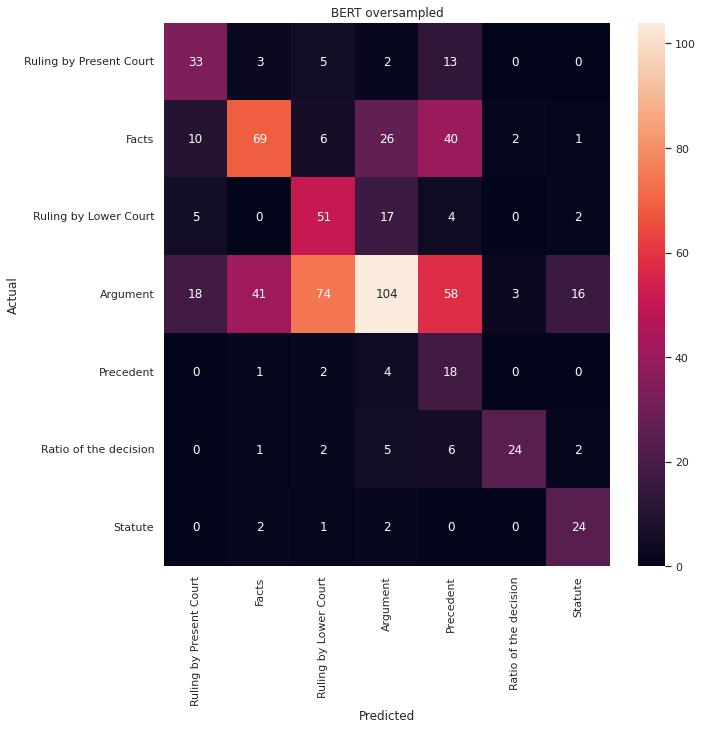

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_file.labels,test_file.text_labels))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['text_labels']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('BERT oversampled')
plt.show()

In [ ]:
run=["nit_agartala_nlp_team_1"]*697
test_file['run_id']=run
test_file.rename(columns = {'ID':'docid_sentid', 'text-labels':'label'}, inplace = True)
test_file

,docid_sentid,Text,labels,processed,pred-labels,text_labels,run_id
0,d1_s1,The present appeal has been filed against the ...,Facts,present appeal filed order dated .. passed int...,6,Ruling by Lower Court,nit_agartala_nlp_team_1
1,d1_s2,Brief facts:,Facts,brief fact :,0,Facts,nit_agartala_nlp_team_1
2,d1_s3,(a) One Shri Lal Babu Priyadarshi the appellan...,Facts,( ) one shri lal babu priyadarshi appellant he...,1,Argument,nit_agartala_nlp_team_1
3,d1_s4,(b) One Shri Amritpal Singh the respondent her...,Facts,( b ) one shri amritpal singh respondent herei...,6,Ruling by Lower Court,nit_agartala_nlp_team_1
4,d1_s5,The respondent herein filed a Notice of Opposi...,Facts,respondent herein filed notice opposition oppo...,0,Facts,nit_agartala_nlp_team_1
...,...,...,...,...,...,...,...
692,d10_s54,The appellant State has taken the stand that t...,Ratio of the decision,appellant state taken stand power appointment ...,4,Precedent,nit_agartala_nlp_team_1
693,d10_s55,In the view that we take that Article 311 has ...,Ratio of the decision,view take article . application case responden...,2,Ratio of the decision,nit_agartala_nlp_team_1
694,d10_s56,"In the result the order of the High Court, dat...",Ruling by Present Court,result order high court dated set aside appeal...,5,Ruling by Present Court,nit_agartala_nlp_team_1
695,d10_s57,"In the circumstances of the case, there will b...",Ruling by Present Court,circumstance case . order cost .,5,Ruling by Present Court,nit_agartala_nlp_team_1


In [ ]:
test_file = test_file.drop(['Text', 'labels', 'processed', 'pred-labels'], axis=1)

In [ ]:
test_file.to_csv('nit_agartala_nlp_team_1.tsv', sep='\t', index=False)

In [ ]:
trrr = pd.read_csv('nit_agartala_nlp_team_1.tsv', sep='\t')

In [ ]:
trrr.head()

,docid_sentid,text_labels,run_id
0,d1_s1,Ruling by Lower Court,nit_agartala_nlp_team_1
1,d1_s2,Facts,nit_agartala_nlp_team_1
2,d1_s3,Argument,nit_agartala_nlp_team_1
3,d1_s4,Ruling by Lower Court,nit_agartala_nlp_team_1
4,d1_s5,Facts,nit_agartala_nlp_team_1
